In [7]:
mErde = 5.9721986*10**24        # kg          : Masse der Erde
mOzean = 0.0014*10**24          # kg          : Masse der Ozeane auf der Erde
RErde = 6.3675*10**6            # kg          : Radius der Erde

mMond = 7.3459*10**22           # kg          : Masse des Mondes 
rMondBahn = 3.836*10**8         # m           : Bahnradius des Mondes, die Umlaufbahn des Mondes
                                #               um die Erde kann als Kreisbahn genähert werden
TMondBahn = 27.32166140*24*3600 # s           : Heutige Periodendauer der Mondumlaufbahn um die Erde

TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

G = 6.67430*10**(-11)           # m^3/(kg*s^2): Gravitationskonstante 

def baryzentrum(m1, m2, r):
    return r*m2/(m1+m2)

from scipy.constants import pi

abstand_baryzentrum_erde = baryzentrum(mErde, mMond, rMondBahn)
vErde = 2*pi*abstand_baryzentrum_erde/TMondBahn
vMond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

def iv_stable_orbit():
    mass = [mErde, mMond]
    # We want the center of mass to be at the origin
    x = [-abstand_baryzentrum_erde, rMondBahn-abstand_baryzentrum_erde]
    y = [0, 0]
    v_x = [0, 0]
    v_y = [-vErde, vMond] # The moon starts in positive, the earth in negative y-direction
    return [mass, x, y, v_x, v_y]

import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.integrate import solve_ivp
from scipy.constants import pi

## Finns Ansatz mit Lagrnange 2.Art

In [8]:
# Note: be very careful with simplify and trigsimp they often don't do anything and take a very long time
def diff_eqs_2_body_problem():
    m_E, m_M = sympy.symbols('m_E m_M', real=True, positive=True)
    mass_vars = [m_E, m_M]
    # Define the masses of the bodies
    masses = [m_E, m_M, m_E, m_M]

    t = sympy.symbols('t', real=True, positive=True) # Time variable for all functions
    x_E, x_M, y_E, y_M = sympy.symbols('x_E x_M y_E y_M', real=True, cls=sympy.Function) # Cartesian coordinates for all bodies

    q_list = (x_E(t), x_M(t), y_E(t), y_M(t)) # Generalized coordinates
    p_list = (m_E*x_E(t).diff(t), m_M*x_M(t).diff(t), m_E*y_E(t).diff(t), m_M*y_M(t).diff(t)) # Generalized momenta

    # Position vector using coordinates
    r = sympy.Matrix([x_E(t), x_M(t), y_E(t), y_M(t)])
    r_dot = r.diff(t) # sympy.simplify(r_dot) Not necessary

    # Calculate the potential energy
    U = -G * m_E * m_M / (sympy.Matrix([x_E(t) - x_M(t), y_E(t) - y_M(t)]).norm())
    T = sum([m*r_dot**2/2 for m, r_dot in zip(masses, r_dot)]) # Kinetic energy

    # print("Velocity vector:")
    # display(r_dot)
    # print("Potential energy:")
    # display(U)
    # print("Kinetic energy:")
    # display(T)
    return (t, U, T, q_list, p_list, mass_vars)

In [9]:
def diff_eqs_4_body_problem():
    t = sympy.symbols('t', real=True, positive=True) # Time variable for all functions
    r_earth = RErde
    # r_earth, G = sympy.symbols('R_E G', real=True, positive=True)
    m_E, m_M, m_1, m_2 = sympy.symbols('m_E m_M m_1 m_2', real=True, positive=True)
    masses = [m_E, m_M, m_E, m_M, m_1, m_1, m_2, m_2] # Define the masses of the bodies
    mass_vars = [m_E, m_M, m_1, m_2]

    # Calculate using hamiltonian mechanics and cartesian coordinates
    x_E, x_M, y_E, y_M, phi_1, phi_2 = sympy.symbols('x_E x_M y_E y_M phi_1 phi_2', real=True, cls=sympy.Function)

    q_list = (x_E(t), x_M(t), y_E(t), y_M(t), phi_1(t), phi_2(t)) # Generalized coordinates
    p_list = (
        m_E*x_E(t).diff(t),
        m_M*x_M(t).diff(t),
        m_E*y_E(t).diff(t),
        m_M*y_M(t).diff(t),
        m_1 * sympy.sqrt((x_E(t).diff(t) - r_earth * phi_1(t).diff(t) * sympy.sin(phi_1(t)))**2 + (y_E(t).diff(t) + r_earth * phi_1(t).diff(t) * sympy.cos(phi_1(t)))**2),
        m_2 * sympy.sqrt((x_E(t).diff(t) - r_earth * phi_2(t).diff(t) * sympy.sin(phi_2(t)))**2 + (y_E(t).diff(t) + r_earth * phi_2(t).diff(t) * sympy.cos(phi_2(t)))**2),
        ) # Generalized momenta
        # m_1*(r_earth)**2*phi_1(t).diff(t),

    # TODO Umsortieren in masses, p_list und r; make the order x,y for all bodies
    # TODO Die Impulse stimmen hier nicht!!!!

    # Position vector using coordinates
    r = sympy.Matrix([  x_E(t), x_M(t), y_E(t), y_M(t), 
                        x_E(t) + r_earth * sympy.cos(phi_1(t)), y_E(t) + r_earth * sympy.sin(phi_1(t)),
                        x_E(t) + r_earth * sympy.cos(phi_2(t)), y_E(t) + r_earth * sympy.sin(phi_2(t))])
    r_dot = r.diff(t) # sympy.simplify(r_dot) Not necessary

    # Calculate the potential energy
    U = - G * m_E * m_M / (sympy.Matrix([x_E(t) - x_M(t), y_E(t) - y_M(t)]).norm()) \
        - G * m_M * m_1 / (sympy.Matrix([x_M(t) - (x_E(t) + r_earth * sympy.cos(phi_1(t))), y_M(t) - (y_E(t) + r_earth * sympy.sin(phi_1(t)))]).norm()) \
        - G * m_M * m_2 / (sympy.Matrix([x_M(t) - (x_E(t) + r_earth * sympy.cos(phi_2(t))), y_M(t) - (y_E(t) + r_earth * sympy.sin(phi_2(t)))]).norm())

    T = sum([m*r_dot**2/2 for m, r_dot in zip(masses, r_dot)]) # Kinetic energy

    # print("Velocity vector:")
    # display(r_dot)
    # print("Potential energy:")
    # display(U)
    print("Kinetic energy:")
    display(T)
    return (t, U, T, q_list, p_list, mass_vars)


In [10]:
def hamilton_eqs(t, U, T, q_list, p_list):
    H = T + U
    diff_eqs = []
    p_const = sympy.symbols('p_const', real=True) # We need to substitute p to be allowed to differentiate it
    # Calculate the Hamilton equations by differentiating the Hamiltonian
    p_subs = [sympy.solve(sympy.Eq(p_const, p), q.diff(t))[0] for p, q in zip(p_list, q_list)] # Coefficients of the momenta to solve the differential equations for accelerations
    print(p_subs)
    for q, p, p_sub in zip(q_list, p_list, p_subs):
        diff_eqs.append(H.subs(q.diff(t), p_sub).diff(p_const).subs(p_const, p)) # Sub in the constant for p, differentiate and then sub back
        # diff_eqs.append(-H.diff(q)) # TODO Solve for q''
        diff_eqs.append(sympy.solve(sympy.Eq(p.diff(t), -H.diff(q)), q.diff(t,t))[0])

    print("Hamiltonian:")
    display(H)
    print("Hamilton equations:")
    for i in range(0, int(len(diff_eqs)/2)):
        print(f'Equation {2*i}:')
        display(q_list[i].diff(t), diff_eqs[2*i])
        print(f'Equation {2*i+1}:')
        display(p_list[i].diff(t), diff_eqs[2*i+1])

    return diff_eqs

def diff_eqs_lambdify(diff_eqs, q_list, mass_vars):
    # Create constants for the generalized coordinates and their derivatives so that we can substitute them in
    q_consts = sympy.symbols(' '.join(str(q) for q in q_list))
    q_dot_consts = sympy.symbols(' '.join(str(q) + '/dt' for q in q_list))
    mass_consts = sympy.symbols(' '.join(str(m) for m in mass_vars))
    # The variable order is pairs of (q, q_dot)
    variable_order = [var for pair in zip(q_consts, q_dot_consts) for var in pair]
    print(f"Variable order: {variable_order}")

    lambdified_diff_eqs = []
    for f in diff_eqs:
        # Using sympys subs function we substitue the generalized coordinates with the variables
        f_subs = f.subs([(m, m_const) for m, m_const in zip(mass_vars, mass_consts)])
        f_subs = f_subs.subs([(q.diff(t), q_dot_const) for q, q_dot_const in zip(q_list, q_dot_consts)]) # We have to substitute the derivatives first!!!
        f_subs = f_subs.subs([(q, q_const) for q, q_const in zip(q_list, q_consts)])
        # Convert the equations to a function with lambdify
        lambdified_diff_eqs.append(sympy.lambdify([t, variable_order, mass_consts], f_subs, modules='numpy'))

    return lambda t, y, mass: np.array([f(t, y, mass) for f in lambdified_diff_eqs])

[p_const/m_E, p_const/m_M, p_const/m_E, p_const/m_M]
Hamiltonian:


-6.6743e-11*m_E*m_M/sqrt((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2) + m_E*Derivative(x_E(t), t)**2/2 + m_E*Derivative(y_E(t), t)**2/2 + m_M*Derivative(x_M(t), t)**2/2 + m_M*Derivative(y_M(t), t)**2/2

Hamilton equations:
Equation 0:


Derivative(x_E(t), t)

Derivative(x_E(t), t)

Equation 1:


m_E*Derivative(x_E(t), (t, 2))

6.6743e-11*m_M*(-x_E(t) + x_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

Equation 2:


Derivative(x_M(t), t)

Derivative(x_M(t), t)

Equation 3:


m_M*Derivative(x_M(t), (t, 2))

6.6743e-11*m_E*(x_E(t) - x_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

Equation 4:


Derivative(y_E(t), t)

Derivative(y_E(t), t)

Equation 5:


m_E*Derivative(y_E(t), (t, 2))

6.6743e-11*m_M*(-y_E(t) + y_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

Equation 6:


Derivative(y_M(t), t)

Derivative(y_M(t), t)

Equation 7:


m_M*Derivative(y_M(t), (t, 2))

6.6743e-11*m_E*(y_E(t) - y_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

Variable order: [x_E(t), x_E(t)/dt, x_M(t), x_M(t)/dt, y_E(t), y_E(t)/dt, y_M(t), y_M(t)/dt]


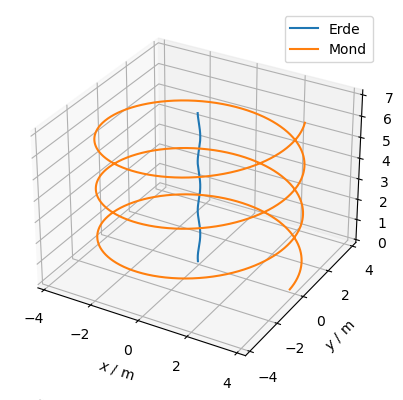

In [11]:
# Same as the solution above just with lagrange / hamilton
masses = [mErde, mMond, mErde, mMond]
t, U, T, q_list, p_list, mass_vars = diff_eqs_2_body_problem()
eq_motion_2body = diff_eqs_lambdify(hamilton_eqs(t, U, T, q_list, p_list), q_list, mass_vars)

# Solve using scipy.integrate.solve_ivp
def four_body_problem(mass: list, x: list, y: list, v_x: list, v_y: list, t_max: float, t_start=0):
    # mass: contains the masses of the bodies

    solution = solve_ivp(eq_motion_2body, [t_start, t_max], [x[0], v_x[0], x[1], v_x[1], y[0], v_y[0], y[1], v_y[1]], args=(mass,), dense_output=True, atol=1e-4*rMondBahn, max_step=TMondBahn/1000)
    return solution

# Plot the solution in polar coordinates
solution = four_body_problem(*iv_stable_orbit(), 3*TMondBahn)

# Plot a 3d phase space diagram
t = solution.t
x1, v_x1, x2, v_x2, y1, v_y1, y2, v_y2 = solution.y
fig = plt.figure()
fig.set_label("3D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, t, label="Erde")
ax.plot(x2, y2, t, label="Mond")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

In [12]:
t, U, T, q_list, p_list, mass_vars = diff_eqs_4_body_problem()
eq_motion_4body = diff_eqs_lambdify(hamilton_eqs(t, U, T, q_list, p_list), q_list, mass_vars)

# Define the initial values
def iv_stable_orbit_4body_tide():
    abstand_baryzentrum_erde = baryzentrum(mErde, mMond, rMondBahn)
    vErde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vMond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

    # Initial conditions for the Earth-Moon system in a stable orbit
    mass = [mErde, mMond, mOzean/2, mOzean/2]
    # We want the center of mass to be at the origin
    x = [-abstand_baryzentrum_erde, rMondBahn-abstand_baryzentrum_erde]
    y = [0, 0]
    v_x = [0, 0]
    v_y = [-vErde, vMond] # The moon starts in positive, the earth in negative y-direction
    # Add the initial values for the flood masses
    angles = [0, pi] # Masses on a line with moon and earth
    # Starting with period of moon
    angle_velocities = [2*pi/TMondBahn, 2*pi/TMondBahn]
    # angle_velocities = [0, 0]
    return mass, x, y, v_x, v_y, angles, angle_velocities

# Solve using scipy.integrate.solve_ivp
def four_body_problem(mass: list, x: list, y: list, v_x: list, v_y: list, angles: list, angle_velocities:list, t_max: float, t_start=0):
    # mass: contains the masses of the bodies
    # angles: initial angles of the flood masses

    # TODO lambdify with mass 
    solution = solve_ivp(eq_motion_4body, [t_start, t_max], [x[0], v_x[0], x[1], v_x[1], y[0], v_y[0], y[1], v_y[1], angles[0], angle_velocities[0], angles[1], angle_velocities[1]], args=(mass,), dense_output=True, atol=1e-4*rMondBahn, max_step=TMondBahn/1000)
    return solution

# Plot the solution in polar coordinates
solution = four_body_problem(*iv_stable_orbit_4body_tide(), 0.5*TMondBahn)
# Set option to print whole numpy arrays
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(solution.y)

# Plot a 3d phase space diagram
t = solution.t
x1, v_x1, x2, v_x2, y1, v_y1, y2, v_y2, phi1, omega1, phi2, omega2 = solution.y
print(phi1)
print(phi2)
print(omega1)
print(omega2)
fig = plt.figure()
fig.set_label("3D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, t, label="Erde")
# ax.plot(x2, y2, t, label="Mond")
ax.plot(x1 + RErde*np.cos(phi1), y1 + RErde*np.sin(phi1), t, label="Ozean 1")
ax.plot(x1 + RErde*np.cos(phi2), y1 + RErde*np.sin(phi2), t, label="Ozean 2")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

# Plot just the earth and the oceans in 2d polar coordinates
fig = plt.figure()
fig.set_label("2D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111)
ax.plot(x1, y1, label="Erde")
ax.plot(x2/20, y2/20, label="Mond")
ax.plot(x1 + RErde*np.cos(phi1), y1 + RErde*np.sin(phi1), label="Ozean 1")
ax.plot(x1 + RErde*np.cos(phi2), y1 + RErde*np.sin(phi2), label="Ozean 2")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.legend()
plt.show()

Kinetic energy:


20272528125000.0*m_1*(-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + 20272528125000.0*m_1*(cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2 + 20272528125000.0*m_2*(-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + 20272528125000.0*m_2*(cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2 + m_E*Derivative(x_E(t), t)**2/2 + m_E*Derivative(y_E(t), t)**2/2 + m_M*Derivative(x_M(t), t)**2/2 + m_M*Derivative(y_M(t), t)**2/2

[p_const/m_E, p_const/m_M, p_const/m_E, p_const/m_M, 7.85237534354142e-25*(1.99999999999999e+17*m_1*(sin(phi_1(t))*Derivative(x_E(t), t) - cos(phi_1(t))*Derivative(y_E(t), t)) - 2.0e+17*sqrt(0.499999999999997*m_1**2*(-2.0*sin(2.0*phi_1(t))*Derivative(x_E(t), t)*Derivative(y_E(t), t) - cos(2.0*phi_1(t))*Derivative(x_E(t), t)**2 + cos(2.0*phi_1(t))*Derivative(y_E(t), t)**2 - Derivative(x_E(t), t)**2 - Derivative(y_E(t), t)**2) + p_const**2))/m_1, 7.85237534354142e-25*(1.99999999999999e+17*m_2*(sin(phi_2(t))*Derivative(x_E(t), t) - cos(phi_2(t))*Derivative(y_E(t), t)) - 2.0e+17*sqrt(0.499999999999997*m_2**2*(-2.0*sin(2.0*phi_2(t))*Derivative(x_E(t), t)*Derivative(y_E(t), t) - cos(2.0*phi_2(t))*Derivative(x_E(t), t)**2 + cos(2.0*phi_2(t))*Derivative(y_E(t), t)**2 - Derivative(x_E(t), t)**2 - Derivative(y_E(t), t)**2) + p_const**2))/m_2]
Hamiltonian:


-1.04818217510797e-17*m_1*m_M/sqrt((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2) + 20272528125000.0*m_1*(-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + 20272528125000.0*m_1*(cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2 - 1.04818217510797e-17*m_2*m_M/sqrt((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_2(t)))**2) + 20272528125000.0*m_2*(-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + 20272528125000.0*m_2*(cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2 - 6.6743e-11*m_E*m_M/sqrt((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2) + m_E*Derivative(x_E(t), t)**2/2 + m_E*Derivative(y_E(t), t)**2/2 + m_M*Derivative(x_M(t), t)**2/2 + m

Hamilton equations:
Equation 0:


Derivative(x_E(t), t)

6367500.0*m_1*(-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))/m_E + 6367500.0*m_2*(-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))/m_E + Derivative(x_E(t), t)

Equation 1:


m_E*Derivative(x_E(t), (t, 2))

4.096e-138*m_M*(2.55903851344719e+92*m_1*((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_2(t)))**2)**(3/2)*(-246639194143429.0*x_E(t) + 246639194143429.0*x_M(t) - 1.57047506870828e+21*cos(phi_1(t))) + 2.55903851344719e+92*m_2*((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2)*(-246639194143429.0*x_E(t) + 246639194143429.0*x_M(t) - 1.57047506870828e+21*cos(phi_2(t))) + 1.6294677734375e+127*m_E*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2)*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506

Equation 2:


Derivative(x_M(t), t)

Derivative(x_M(t), t)

Equation 3:


m_M*Derivative(x_M(t), (t, 2))

2.58522806984136e-31*m_1*x_E(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2) - 2.58522806984136e-31*m_1*x_M(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2) + 1.64614397347148e-24*m_1*cos(phi_1(t))/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2) + 2.58522806984136e-31*m_2*x_E(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_2(t)))**2)**(3/2) - 2.58522806984136e-31*m_2*x_M(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_2(t)))**2)**(3/2) 

Equation 4:


Derivative(y_E(t), t)

6367500.0*m_1*(cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))/m_E + 6367500.0*m_2*(cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))/m_E + Derivative(y_E(t), t)

Equation 5:


m_E*Derivative(y_E(t), (t, 2))

4.096e-138*m_M*(2.55903851344719e+92*m_1*((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_2(t)))**2)**(3/2)*(-246639194143429.0*y_E(t) + 246639194143429.0*y_M(t) - 1.57047506870828e+21*sin(phi_1(t))) + 2.55903851344719e+92*m_2*((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2)*(-246639194143429.0*y_E(t) + 246639194143429.0*y_M(t) - 1.57047506870828e+21*sin(phi_2(t))) + 1.6294677734375e+127*m_E*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2)*((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506

Equation 6:


Derivative(y_M(t), t)

Derivative(y_M(t), t)

Equation 7:


m_M*Derivative(y_M(t), (t, 2))

2.58522806984136e-31*m_1*y_E(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2) - 2.58522806984136e-31*m_1*y_M(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2) + 1.64614397347148e-24*m_1*sin(phi_1(t))/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_1(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_1(t)))**2)**(3/2) + 2.58522806984136e-31*m_2*y_E(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_2(t)))**2)**(3/2) - 2.58522806984136e-31*m_2*y_M(t)/((1.57047506870828e-7*x_E(t) - 1.57047506870828e-7*x_M(t) + cos(phi_2(t)))**2 + (1.57047506870828e-7*y_E(t) - 1.57047506870828e-7*y_M(t) + sin(phi_2(t)))**2)**(3/2) 

Equation 8:


Derivative(phi_1(t), t)

1.0*m_1*sqrt((-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*(Derivative(x_E(t), t) - 5.0e-18*(1.99999999999999e+17*m_1*(sin(phi_1(t))*Derivative(x_E(t), t) - cos(phi_1(t))*Derivative(y_E(t), t)) - 1.2735e+24*sqrt(m_1**2*((-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2) + 1.23319597071714e-14*m_1**2*(-2.0*sin(2.0*phi_1(t))*Derivative(x_E(t), t)*Derivative(y_E(t), t) - cos(2.0*phi_1(t))*Derivative(x_E(t), t)**2 + cos(2.0*phi_1(t))*Derivative(y_E(t), t)**2 - Derivative(x_E(t), t)**2 - Derivative(y_E(t), t)**2)))*sin(phi_1(t))/m_1)*sin(phi_1(t))/sqrt(m_1**2*((-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2) +

Equation 9:


6367500.0*m_1*((-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))*(-2*sin(phi_1(t))*Derivative(phi_1(t), (t, 2)) - 2*cos(phi_1(t))*Derivative(phi_1(t), t)**2 + 3.14095013741657e-7*Derivative(x_E(t), (t, 2)))/2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))*(-2*sin(phi_1(t))*Derivative(phi_1(t), t)**2 + 2*cos(phi_1(t))*Derivative(phi_1(t), (t, 2)) + 3.14095013741657e-7*Derivative(y_E(t), (t, 2)))/2)/sqrt((-sin(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)

1.25638005496663e-86*(5.14419991709839e+75*m_M*sqrt((sin(phi_1(t))*Derivative(phi_1(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*x_E(t)*sin(phi_1(t)) - 5.14419991709839e+75*m_M*sqrt((sin(phi_1(t))*Derivative(phi_1(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*x_M(t)*sin(phi_1(t)) - 5.14419991709839e+75*m_M*sqrt((sin(phi_1(t))*Derivative(phi_1(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*y_E(t)*cos(phi_1(t)) + 5.14419991709839e+75*m_M*sqrt((sin(phi_1(t))*Derivative(phi_1(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_1(t))*Derivative(phi_1(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*y_M(t)*cos(phi_1(t)) + 1.98984374999999e+106*sqrt((sin(phi_1(t))*Derivative(phi_1

Equation 10:


Derivative(phi_2(t), t)

1.0*m_2*sqrt((-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*(Derivative(x_E(t), t) - 5.0e-18*(1.99999999999999e+17*m_2*(sin(phi_2(t))*Derivative(x_E(t), t) - cos(phi_2(t))*Derivative(y_E(t), t)) - 1.2735e+24*sqrt(m_2**2*((-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2) + 1.23319597071714e-14*m_2**2*(-2.0*sin(2.0*phi_2(t))*Derivative(x_E(t), t)*Derivative(y_E(t), t) - cos(2.0*phi_2(t))*Derivative(x_E(t), t)**2 + cos(2.0*phi_2(t))*Derivative(y_E(t), t)**2 - Derivative(x_E(t), t)**2 - Derivative(y_E(t), t)**2)))*sin(phi_2(t))/m_2)*sin(phi_2(t))/sqrt(m_2**2*((-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2) +

Equation 11:


6367500.0*m_2*((-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))*(-2*sin(phi_2(t))*Derivative(phi_2(t), (t, 2)) - 2*cos(phi_2(t))*Derivative(phi_2(t), t)**2 + 3.14095013741657e-7*Derivative(x_E(t), (t, 2)))/2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))*(-2*sin(phi_2(t))*Derivative(phi_2(t), t)**2 + 2*cos(phi_2(t))*Derivative(phi_2(t), (t, 2)) + 3.14095013741657e-7*Derivative(y_E(t), (t, 2)))/2)/sqrt((-sin(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)

1.25638005496663e-86*(5.14419991709839e+75*m_M*sqrt((sin(phi_2(t))*Derivative(phi_2(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*x_E(t)*sin(phi_2(t)) - 5.14419991709839e+75*m_M*sqrt((sin(phi_2(t))*Derivative(phi_2(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*x_M(t)*sin(phi_2(t)) - 5.14419991709839e+75*m_M*sqrt((sin(phi_2(t))*Derivative(phi_2(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*y_E(t)*cos(phi_2(t)) + 5.14419991709839e+75*m_M*sqrt((sin(phi_2(t))*Derivative(phi_2(t), t) - 1.57047506870828e-7*Derivative(x_E(t), t))**2 + (cos(phi_2(t))*Derivative(phi_2(t), t) + 1.57047506870828e-7*Derivative(y_E(t), t))**2)*y_M(t)*cos(phi_2(t)) + 1.98984374999999e+106*sqrt((sin(phi_2(t))*Derivative(phi_2

Variable order: [x_E(t), x_E(t)/dt, x_M(t), x_M(t)/dt, y_E(t), y_E(t)/dt, y_M(t), y_M(t)/dt, phi_1(t), phi_1(t)/dt, phi_2(t), phi_2(t)/dt]


NameError: name 'Derivative' is not defined